# PacWave Resource Assessment

This example notebook provides an example using MHKiT to perform a resource assessment similar to Dunkel et. al at the PACWAVE site following the IEC 62600-101 where applicable. PacWave is an open ocean, grid-connected, full-scale test facility consisting of two sites (PacWave-North & PacWave-South) for wave energy conversion technology testing located just a few miles from the deep-water port of Newport, Oregon. This example notebook performs a resource analysis using omni-directional wave data from a nearby NDBC buoy and replicates plots created by Dunkel et. al and prescribed by IEC TS 62600-101 using these data.

Note: this example notebook requires the Python package folium which is not a requirement of MHKiT and may need to be pip installed seperately.

Dunkle, Gabrielle, et al. "PacWave Wave Resource Assessment." (2020).

In [1]:
import mhkit
from mhkit.wave import resource, performance, graphics, contours
from sklearn.mixture import GaussianMixture
from mhkit.wave.io import ndbc
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
import pandas as pd
import numpy as np
import folium
import os

import matplotlib.pylab as pylab

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (15, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

## Buoy Location

The closest NDBC buoy to PacWave is located further from shore than the PacWave sites, as can be seen in the map below. The buoy used in this analysis is NDBC buoy 46050 (blue marker). The analysis here will focus on PacWave-South (red marker) which is approximately 40 km closer to shore than the NDBC buoy. PacWave-North is shown by the green marker. 

In [2]:
m = folium.Map(
    location=[44.613600975457715, -123.74317583354498],
    zoom_start=9,
    tiles="CyclOSM",
    control_scale=True,
)

tooltip = "NDBC 46050"
folium.Marker(
    [44.669, -124.546], popup="<i> Water depth: 160 m</i>", tooltip=tooltip
).add_to(m)

tooltip = "PACWAVE North"
folium.Marker(
    [44.69, -124.13472222222222],
    tooltip=tooltip,
    icon=folium.Icon(color="green", icon="th-large"),
).add_to(m)
tooltip = "PACWAVE South"
folium.Marker(
    [44.58444444444444, -124.2125],
    tooltip=tooltip,
    icon=folium.Icon(color="red", icon="th"),
).add_to(m)

m.save("index.png")

m

## Bouy Metadata

The MHKiT function `get_buoy_metadata` will fetch the metadata for a given National Data Buoy Center (NDBC) buoy. In this case the station number nearest to PACWAVE is '46050'. This metadata can provide important background information about the buoy to help users understand the source of the data they are working with and ensure that the buoy's location and characteristics are suitable for their specific analysis. Note that optional buoy keys will be assigned as metadata keys with empty values. This can be seen in the example below for "SCOOP Payload".

In [3]:
# Get buoy metadata
buoy_number = "46050"
buoy_metadata = ndbc.get_buoy_metadata(buoy_number)
print("Buoy Metadata:")
for key, value in buoy_metadata.items():
    print(f"{key}: {value}")

Buoy Metadata:
buoy: Station 46050(LLNR 641)- STONEWALL BANK - 20NM West of Newport, OR
provider: Owned and maintained by National Data Buoy Center
type: 3-meter foam buoy
SCOOP payload: 
lat: 44.669
lon: 124.546
Site elevation: sea level
Air temp height: 3.7 m above site elevation
Anemometer height: 4.1 m above site elevation
Barometer elevation: 2.7 m above mean sea level
Sea temp depth: 1.5 m below water line
Water depth: 160 m
Watch circle radius: 243 yards


## Import Data from NDBC

NDBC buoy data can be imported using MHKiT's NDBC submodule. At the top of this script, we have already imported this module using the call `from mhkit.wave.io import ndbc`.  Here, we will use the `available_data` function to ask the NDBC servers what data is available for buoy 46050. We will also need to specify what parameter we are interested in. In this case, we are requesting wave spectral wave density data for which NDBC uses the keyword 'sweden'. We then pass the data of interest using the filenames of the returned data into the `request_data` function to retrieve the requested data from the NDBC servers.

In [4]:
# Spectral wave density for buoy 46050
parameter = "swden"

# Request list of available files
ndbc_available_data = ndbc.available_data(parameter, buoy_number)

# Pass file names to NDBC and request the data
filenames = ndbc_available_data["filename"]
ndbc_requested_data = ndbc.request_data(parameter, filenames)

ndbc_requested_data["2020"]

,#YY,MM,DD,hh,mm,.0200,.0325,.0375,.0425,.0475,...,.3300,.3400,.3500,.3650,.3850,.4050,.4250,.4450,.4650,.4850
0,2020,1,1,0,40,0.0,0.0,0.00,2.28,2.99,...,0.19,0.22,0.15,0.12,0.12,0.06,0.04,0.03,0.02,0.02
1,2020,1,1,1,40,0.0,0.0,0.37,3.30,3.12,...,0.20,0.15,0.14,0.14,0.07,0.05,0.04,0.02,0.03,0.01
2,2020,1,1,2,40,0.0,0.0,0.00,4.80,5.16,...,0.07,0.18,0.14,0.10,0.13,0.08,0.04,0.02,0.01,0.01
3,2020,1,1,3,40,0.0,0.0,0.00,1.70,1.38,...,0.30,0.14,0.11,0.08,0.10,0.03,0.03,0.03,0.01,0.00
4,2020,1,1,4,40,0.0,0.0,0.24,5.72,7.90,...,0.12,0.18,0.07,0.10,0.12,0.04,0.03,0.03,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,2020,12,31,19,40,0.0,0.0,0.00,0.00,0.00,...,0.11,0.08,0.08,0.08,0.03,0.02,0.01,0.01,0.01,0.01
8617,2020,12,31,20,40,0.0,0.0,0.00,0.00,0.99,...,0.07,0.10,0.06,0.06,0.05,0.04,0.03,0.03,0.01,0.01
8618,2020,12,31,21,40,0.0,0.0,0.00,0.00,0.01,...,0.05,0.06,0.06,0.06,0.04,0.03,0.03,0.02,0.01,0.01
8619,2020,12,31,22,40,0.0,0.0,0.00,0.00,0.93,...,0.10,0.09,0.09,0.10,0.04,0.03,0.02,0.02,0.01,0.01


### Create DateTime index

The data returned from NDBC include separate columns for year, month, day, etc. as shown above. MHKiT has a built-in function to convert these separate columns into a DateTime index for the DataFrame and remove these date ant time columns from the data leaving only the frequency data. The resultant DataFrame is shown below.

In [5]:
ndbc_data = {}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

ndbc_data["2020"]

,0.0200,0.0325,0.0375,0.0425,0.0475,0.0525,0.0575,0.0625,0.0675,0.0725,...,0.3300,0.3400,0.3500,0.3650,0.3850,0.4050,0.4250,0.4450,0.4650,0.4850
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:40:00,0.0,0.0,0.00,2.28,2.99,0.00,0.00,2.91,7.23,10.65,...,0.19,0.22,0.15,0.12,0.12,0.06,0.04,0.03,0.02,0.02
2020-01-01 01:40:00,0.0,0.0,0.37,3.30,3.12,0.94,1.49,3.13,8.58,12.09,...,0.20,0.15,0.14,0.14,0.07,0.05,0.04,0.02,0.03,0.01
2020-01-01 02:40:00,0.0,0.0,0.00,4.80,5.16,0.66,1.44,4.19,14.32,26.21,...,0.07,0.18,0.14,0.10,0.13,0.08,0.04,0.02,0.01,0.01
2020-01-01 03:40:00,0.0,0.0,0.00,1.70,1.38,0.00,0.47,2.91,15.89,32.12,...,0.30,0.14,0.11,0.08,0.10,0.03,0.03,0.03,0.01,0.00
2020-01-01 04:40:00,0.0,0.0,0.24,5.72,7.90,2.75,0.59,4.39,17.49,18.75,...,0.12,0.18,0.07,0.10,0.12,0.04,0.03,0.03,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:40:00,0.0,0.0,0.00,0.00,0.00,6.15,21.06,28.97,21.23,20.75,...,0.11,0.08,0.08,0.08,0.03,0.02,0.01,0.01,0.01,0.01
2020-12-31 20:40:00,0.0,0.0,0.00,0.00,0.99,5.20,21.62,26.23,27.02,32.43,...,0.07,0.10,0.06,0.06,0.05,0.04,0.03,0.03,0.01,0.01
2020-12-31 21:40:00,0.0,0.0,0.00,0.00,0.01,0.58,6.02,21.26,18.66,13.60,...,0.05,0.06,0.06,0.06,0.04,0.03,0.03,0.02,0.01,0.01


## Calculate QoIs from Spectral Data

Here we will calculate quantities of interest (QoIs) using the spectral data by applying the appropriate MHKiT function, appending the results to a list, then combining all the lists into a single DataFrame. 

In [6]:
# Intialize empty lists to store the results from each year
Hm0_list = []
Te_list = []
J_list = []
Tp_list = []
Tz_list = []

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    data_raw = ndbc_data[year]
    year_data = data_raw[data_raw != 999.0].dropna()
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))
    J_list.append(resource.energy_flux(year_data.T, h=399.0))

    # Tp_list.append(resource.peak_period(year_data.T))
    fp = year_data.T.idxmax(axis=0)
    Tp = 1/fp
    Tp = pd.DataFrame(Tp, index=year_data.T.columns, columns=["Tp"])
    Tp_list.append(Tp)

    Tz_list.append(resource.average_zero_crossing_period(year_data.T))

# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list, axis=0)
Tp = pd.concat(Tp_list, axis=0)
Hm0 = pd.concat(Hm0_list, axis=0)
J = pd.concat(J_list, axis=0)
Tz = pd.concat(Tz_list, axis=0)
data = pd.concat([Hm0, Te, Tp, J, Tz], axis=1)

# Calculate wave steepness
data["Sm"] = data.Hm0 / (9.81 / (2 * np.pi) * data.Tz**2)

# Drop any NaNs created from the calculation of Hm0 or Te
data.dropna(inplace=True)
# Sort the DateTime index
data.sort_index(inplace=True)

## Average Annual Energy Table

A comparison of where a resource's most energetic sea states are compared with how frequently they occur can be performed using the `plot_avg_annual_energy_matrix` function. For a given set of data, the function will bin the data by Hm0 and Te. Within each bin, the average annual power and avg number of hours are calculated. A contour of the average annual power is plotted in each bin and the average number of hours that sea state occurs is plotted as text in the box.

The figure below shows that the most frequent sea state occurs on average 527 hours per year at an energy period of 7.5 s and a significant wave height of 1.25 m. Dunkle et al. reported a similar most frequent sea state with a slightly longer energy period at 8.5 s and having a 1.75-m wave height for 528 hours per year. The highest average annual energy sea state at buoy 46050 occurs at an energy period of 9.5 s and a significant wave height of 2.75 m and occurs on average for 168 hours per year. Further, Dunkle et al. reported the most energetic sea state on average to occur at 2.75 m and 10.5 s for 231 hours per year. 

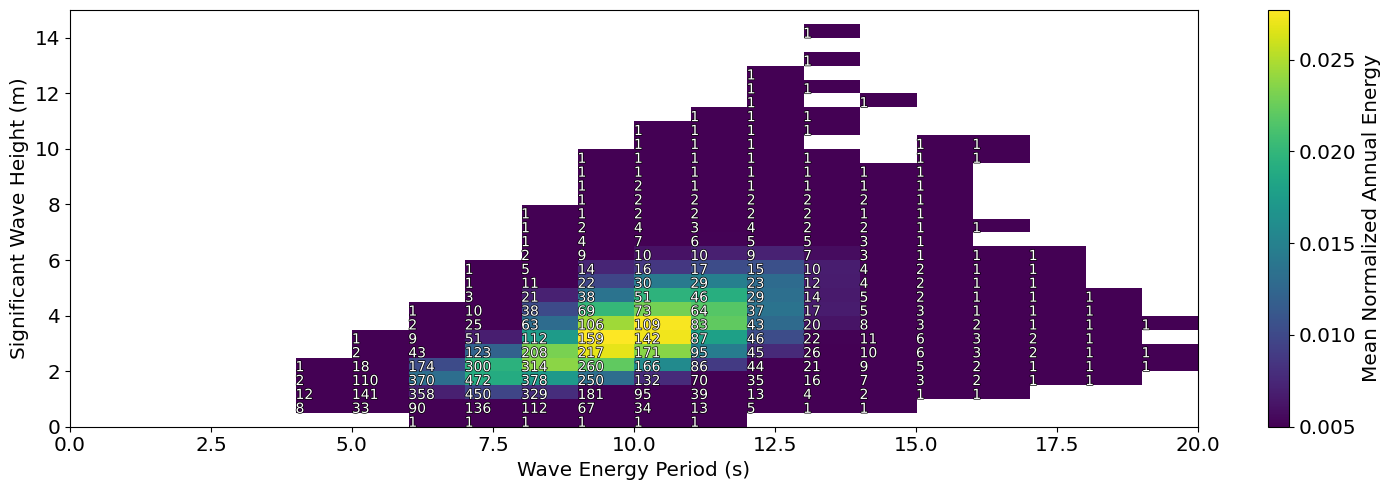

In [7]:
# Start by cleaning the data of outliers
data_clean = data[data.Hm0 < 20]
sigma = data_clean.J.std()
data_clean = data_clean[data_clean.J > (data_clean.J.mean() - 0.9 * sigma)]

# Organizing the cleaned data
Hm0 = data_clean.Hm0
Te = data_clean.Te
J = data_clean.J

# Setting the bins for the resource frequency and power distribution
Hm0_bin_size = 0.5
Hm0_edges = np.arange(0, 15 + Hm0_bin_size, Hm0_bin_size)
Te_bin_size = 1
Te_edges = np.arange(0, 20 + Te_bin_size, Te_bin_size)

fig = mhkit.wave.graphics.plot_avg_annual_energy_matrix(
    Hm0, Te, J, Hm0_edges=Hm0_edges, Te_edges=Te_edges
)

## Wave Power by Month

We can create a plot of monthly statistics for a quantity of interest as shown in the code and plots below. These plots show the median value of a month over the dataset timeframe and bound the value by its 25th and 75th percentile by a shaded region.

Comparing the plots below to the analysis performed by Dunkle et. al we can see that in the top subplot the significant wave height has a maximum mean value in December at 3.11 m, which corresponds well with Fig. 5 in Dunkel et. al. The higher significant wave height also brings higher variability in the winter months than in the summer months, which shows a minimum value around 1.44 m in August. The second and third subplots below show an energy period and peak period each having a maximum value in January at 10.3 s and 12.5 s, respectively. The minimums also correspond to the same month of July with values of 7.12 s, and 8.33 s for the energy period and peak period, respectively.  Dunkle et al. report a minimum energy period value of 8.5 s in July and a maximum energy period of 11.3 s in February and do not report peak period monthly statistics.

The maximum energy flux occurs in December at 48889 kW/m while the minimum occurs in August at 7212 kW/m. These values come in lower than the results from Dunkel et. al., which report values ranging between 70 and 80 kW/m in the winter months and a mean around 20 kW/m in the summer months. The average monthly steepness stays relatively constant throughout the year, ranging between 0.0265 and 0.0313. A discussion of monthly wave steepness was not held in Dunkel et. al but would be interesting to compare for the PACWAVE-South site. 


--------------------------------------------
Hm0 max:3.0878, month: 12
Hm0 min:1.4344, month: 8
--------------------------------------------
Te max:10.4087, month: 1
Te min:7.0886, month: 7
--------------------------------------------
Tp max:12.5, month: 1
Tp min:8.3333, month: 7
--------------------------------------------
J max:47358.4194, month: 12
J min:7155.582, month: 8
--------------------------------------------
Tz max:8.0446, month: 1
Tz min:5.6926, month: 7
--------------------------------------------
Sm max:0.0316, month: 12
Sm min:0.0264, month: 9


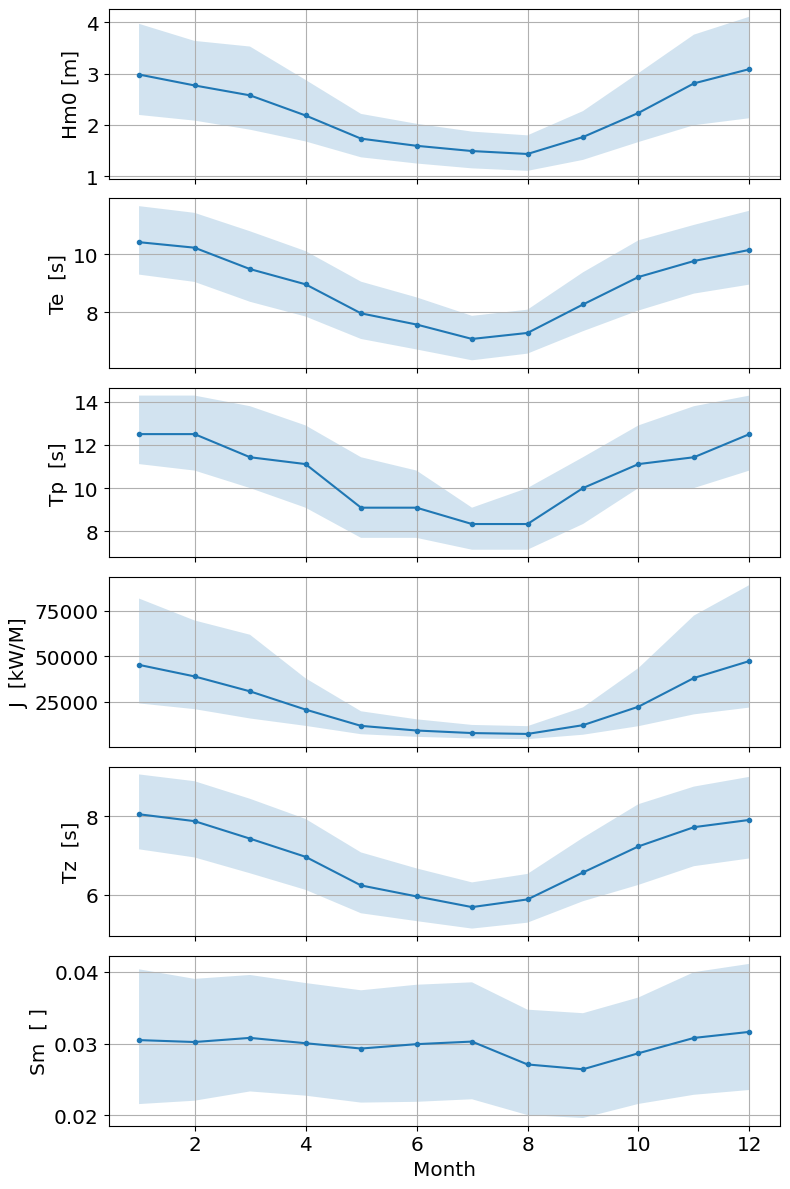

In [8]:
months = data_clean.index.month
data_group = data_clean.groupby(months)

QoIs = data_clean.keys()
fig, axs = plt.subplots(len(QoIs), 1, figsize=(8, 12), sharex=True)
# shade between 25% and 75%
QoIs = data_clean.keys()
for i in range(len(QoIs)):
    QoI = QoIs[i]
    axs[i].plot(data_group.median()[QoI], marker=".")

    axs[i].fill_between(
        months.unique(),
        data_group.describe()[QoI, "25%"],
        data_group.describe()[QoI, "75%"],
        alpha=0.2,
    )
    axs[i].grid()
    mx = data_group.median()[QoI].max()
    mx_month = data_group.median()[QoI].argmax() + 1
    mn = data_group.median()[QoI].min()
    mn_month = data_group.median()[QoI].argmin() + 1
    print("--------------------------------------------")
    print(f"{QoI} max:{np.round(mx,4)}, month: {mx_month}")
    print(f"{QoI} min:{np.round(mn,4)}, month: {mn_month}")

plt.setp(axs[5], xlabel="Month")

plt.setp(axs[0], ylabel=f"{QoIs[0]} [m]")
plt.setp(axs[1], ylabel=f"{QoIs[1]}  [s]")
plt.setp(axs[2], ylabel=f"{QoIs[2]}  [s]")
plt.setp(axs[3], ylabel=f"{QoIs[3]}  [kW/M]")
plt.setp(axs[4], ylabel=f"{QoIs[4]}  [s]")
plt.setp(axs[5], ylabel=f"{QoIs[5]}  [ ]")


plt.tight_layout()

plt.savefig("40650QoIs.png")

## Monthly Cumulative Distribution

A cumulative distribution of the energy flux, as described in the IEC TS 62600-101 is created using MHKiT as shown below. The summer months have a lower maximum energy flux and are found left of the black data line representing the cumulative distribution of all collected data. April and October most closely follow the overall energy flux distribution while the winter months show less variation than the summer months in their distribution.


(1000, 1000000.0)

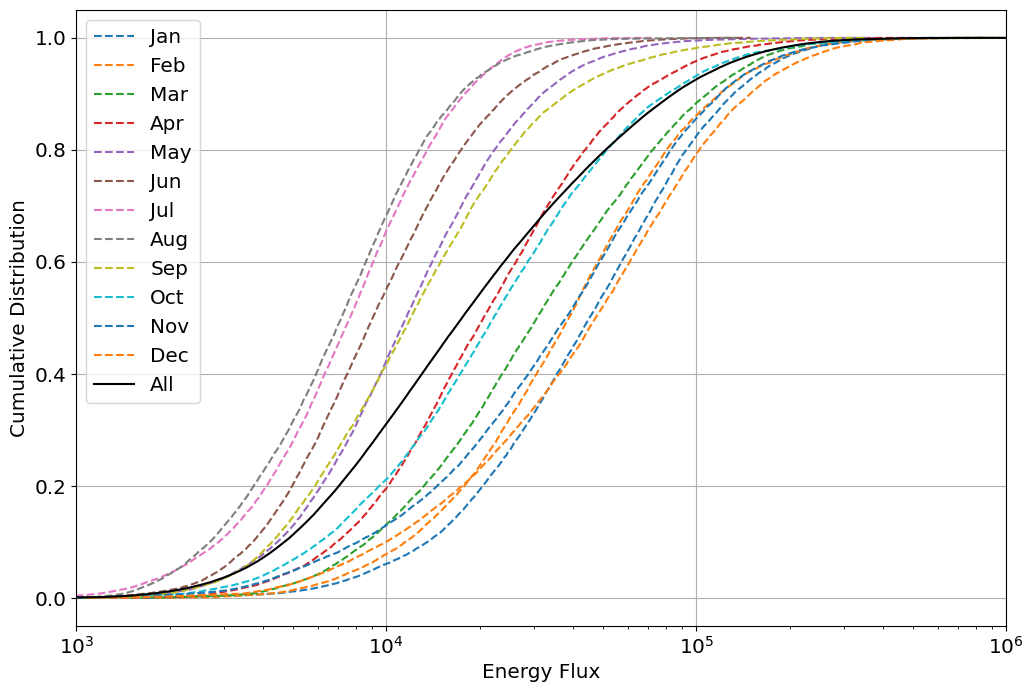

In [9]:
ax = graphics.monthly_cumulative_distribution(data_clean.J)
plt.xlim([1000, 1e6])

## Extreme Sea States

Fifty and one-hundred year contours were created using the environmental contours functions. The environmental contours function in MHKiT was adapted from the Wave Energy Converter Design Response Toolbox (WDRT) [Coe et. al, 2016].  The methodologies for calculating environmental contours are an active area of research and differences in methodology can be seen when comparing to the results. Dunkle et al. present 16.68 s and 12.49 m as the peak energy period and significant wave height for the 50-year contour, whereas the methodology applied in MHKiT returns a 50-year peak at 15.71 m and 16.24 s. Dunkle et al. present a peak for the 100-year contour at 13.19 m and 16.85 s, whereas the MHKiT functionality returns 16.62 m and 16.43 s. 

Coe, Ryan, Michelen, Carlos, Eckert-Gallup, Aubrey, Yu, Yi-Hsiang, and Van Rij, Jennifer. (2016, March 30). WEC Design Response Toolbox v. 1.0 (Version 00) [Computer software]. https://www.osti.gov//servlets/purl/1312743.

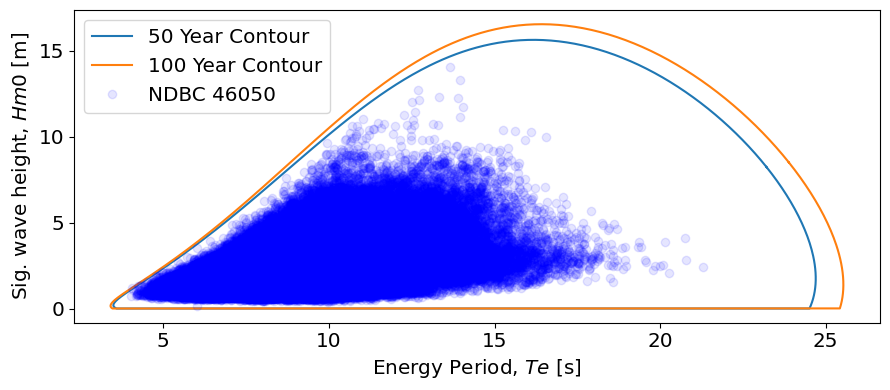

In [10]:
# Delta time of sea-states
dt = (data_clean.index[2] - data_clean.index[1]).seconds

# Return period (years) of interest
period = 100
copulas100 = contours.environmental_contours(
    data.Hm0,
    data.Te,
    dt,
    period,
    method="PCA",
)

period = 50
copulas50 = contours.environmental_contours(
    data.Hm0,
    data.Te,
    dt,
    period,
    method="PCA",
)


Te_data = np.array(data_clean.Te)
Hm0_data = np.array(data_clean.Hm0)

Hm0_contours = [copulas50["PCA_x1"], copulas100["PCA_x1"]]
Te_contours = [copulas50["PCA_x2"], copulas100["PCA_x2"]]

fig, ax = plt.subplots(figsize=(9, 4))
ax = graphics.plot_environmental_contour(
    Te_data,
    Hm0_data,
    Te_contours,
    Hm0_contours,
    data_label="NDBC 46050",
    contour_label=["50 Year Contour", "100 Year Contour"],
    x_label="Energy Period, $Te$ [s]",
    y_label="Sig. wave height, $Hm0$ [m]",
    ax=ax,
)
plt.legend(loc="upper left")
plt.tight_layout()

In [11]:
print(f"50-year: Hm0 max {copulas50['PCA_x1'].max().round(1)}")
print(
    f"50-year: Te at Hm0 max {copulas50['PCA_x2'][copulas50['PCA_x1'].argmax()].round(1)}"
)
print("\n")
print(f"100-year: Hm0 max {copulas100['PCA_x1'].max().round(1)}")
print(
    f"100-year: Te at Hm0 max { copulas100['PCA_x2'][copulas100['PCA_x1'].argmax()].round(1)}"
)

50-year: Hm0 max 15.6
50-year: Te at Hm0 max 16.2


100-year: Hm0 max 16.5
100-year: Te at Hm0 max 16.4


## Calculate Sea State Representative Clusters

The above methodology discusses ways to apply MHKiT and industry standards to characterize a wave energy resource. When optimizing a WEC design through simulation it is customary to consider a limited number of representative sea states as the full set of sea states is intractable to simulate during design optimization. Down-selecting a limited number of sea states results in loss of information. The following analysis will compare a full 2D histogram result to several representative sea state clusters typically referred to as K-means clusters.

We first calculate the total energy flux for the provided data.

In [12]:
nHours = (data_clean.index[1] - data_clean.index[0]).seconds / 3600
Total = data_clean.J.sum() * nHours
print(f"{Total} (W*hr)/m")

7987763740.503419 (W*hr)/m


### Down Select by 2D Histogram 

Knowing the total energy flux we may calculate the 2D histogram result and compare it to the total result. We expect this value to near unity. While we have down-selected the number of sea states the histogram is still 100 bins and this is still not generally tractable for WEC optimization. We could continue to reduce the number of histogram bins, however, in sticking with this technique we are generally constrained to a cartesian set of bins. 

In [13]:
Jsum, xe, ye, bn = stats.binned_statistic_2d(
    data_clean.Hm0, data_clean.Te, data_clean.J, statistic="sum"
)  # ,bins=[Te_bins, Hm0_bins])

hist_result = np.round(Jsum.sum().sum() / Total, 4)
print(f"{hist_result} = (2D Histogram J) / (1-year total J) ")

1.0 = (2D Histogram J) / (1-year total J) 


### Down Select by K-means clusters

By choosing a limited number of data clusters we should be able to choose some minimum representative number for our sea state which still captures the resource well. To calculate these we will use a Gaussian-mixture model (a more general K-means method) which allows us to assign data points to an individual cluster and assign weights based on the density of points in that cluster. We will consider varying numbers of clusters (`N=[4, 8, 16, 32, 64]`) and then calculate the representative energy in each cluster by representing each sea state as a Bretchnider spectrum. In the following code, we will create a plot for each of our N clusters and show where the provided data points fall within each cluster.

[Text(0.5, 0, 'Sig. wave height, $Hm0$ [m')]

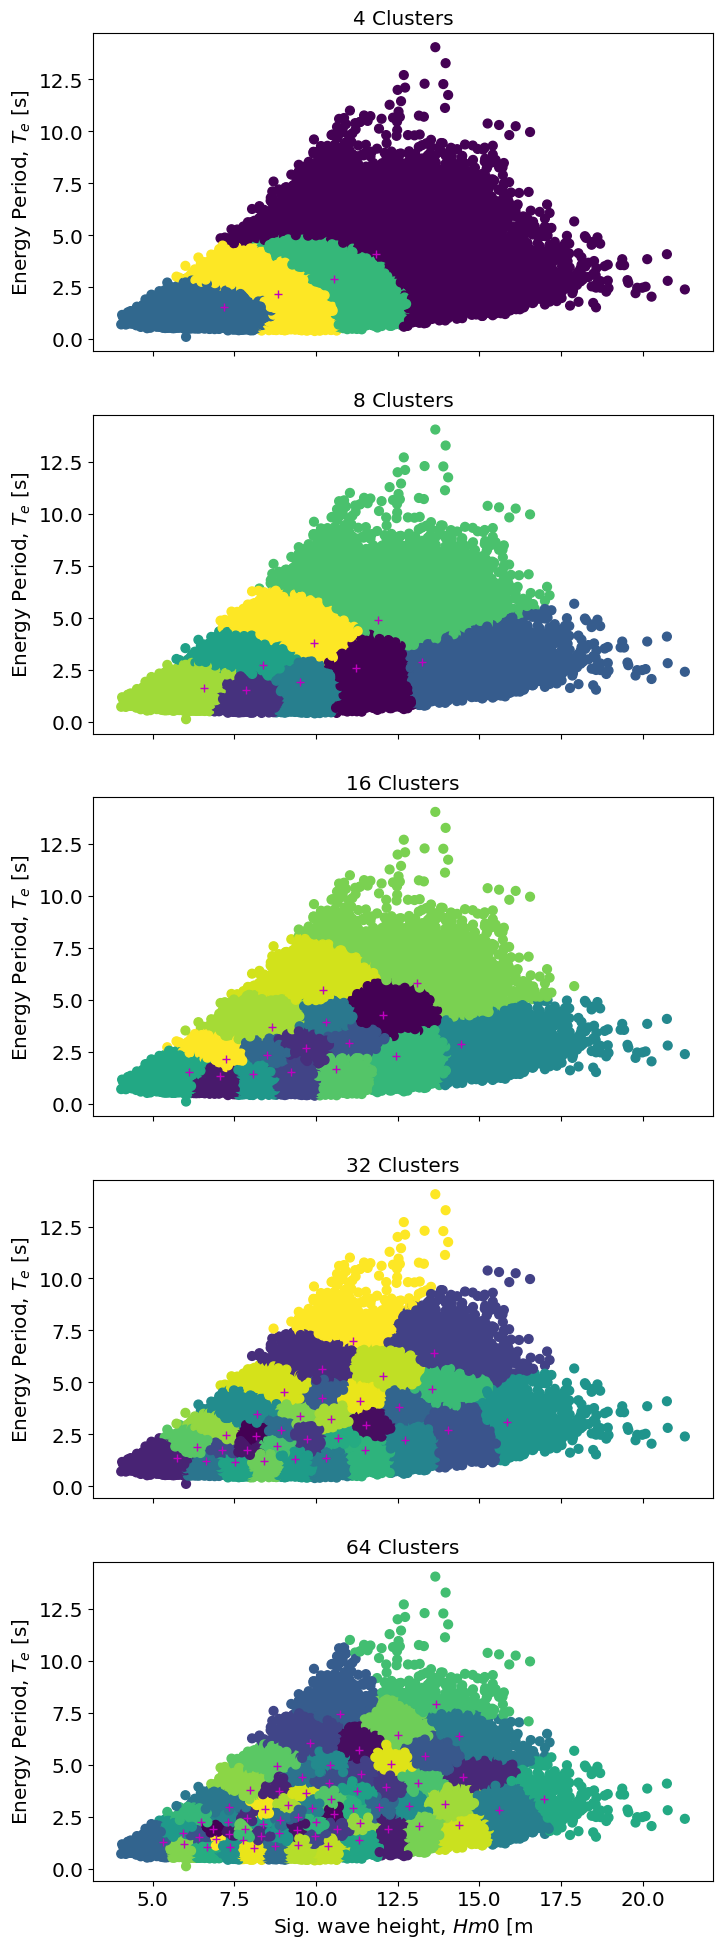

In [14]:
# Compute Gaussian Mixture Model for each number of clusters
clusters = [4, 8, 16, 32, 64]
X = np.vstack((data_clean.Te.values, data_clean.Hm0.values)).T
fig, axs = plt.subplots(len(clusters), 1, figsize=(8, 24), sharex=True)

results = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster).fit(X)

    # Save centers and weights
    result = pd.DataFrame(gmm.means_, columns=["Te", "Hm0"])
    result["weights"] = gmm.weights_

    result["Tp"] = result.Te / 0.858
    results[cluster] = result

    labels = gmm.predict(X)

    i = clusters.index(cluster)
    axs[i].scatter(data_clean.Te.values, data_clean.Hm0.values, c=labels, s=40)
    axs[i].plot(result.Te, result.Hm0, "m+")
    axs[i].title.set_text(f"{cluster} Clusters")
    plt.setp(axs[i], ylabel="Energy Period, $T_e$ [s]")
plt.setp(axs[len(clusters) - 1], xlabel="Sig. wave height, $Hm0$ [m")

### Compare Representative Sea State Energy to Total

Lastly, we will compare each sea state's representative energy to the original total energy of the dataset. As expected we observe increasing agreement with the original total energy as the number of clusters increases.


In [15]:
w = ndbc_data[year].columns.values
f = w / 2 * np.pi


for N in results:
    result = results[N]
    J = []
    for i in range(len(result)):
        b = resource.jonswap_spectrum(f, result.Tp[i], result.Hm0[i])
        J.extend([resource.energy_flux(b, h=399.0).values[0][0]])

    result["J"] = J
    results[N] = result

ratios = {}
for N in results:
    J_hr = results[N].J * len(data_clean)
    total_weighted_J = (J_hr * results[N].weights).sum()
    normalized_weighted_J = total_weighted_J / Total
    ratios[N] = np.round(normalized_weighted_J, 4)

pd.Series(ratios)

4     0.9097
8     0.9381
16    0.9827
32    1.0016
64    1.0164
dtype: float64